# Анализ результатов AB тестирования

Цель - оценить корректность проведения теста и проанализировать его результаты.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
                   - конверсии в просмотр карточек товаров — событие `product_page`,
                   - просмотры корзины — `product_cart`,
                   - покупки — `purchase`

In [1]:
# Импортириуем все необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import math as mth

!pip install kaleido
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

## Загрузка данных и обзор

In [2]:
#загрузка данных

import pandas as pd


marketing_events = pd.read_csv('ab_project_marketing_events.csv')
events = pd.read_csv('final_ab_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
participants = pd.read_csv('final_ab_participants.csv')

In [3]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#выведем основную информацию

marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


- Пропусков в данных нет;
- Наименования столбцов приведены к нижнему регистру, не требуют корректировки;
- Привести столбцы `start_dt`, `finish_dt` к верному типу - datetime.

In [5]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
#выведем основную информацию

events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


- Наблюдаются пропуски в столбце `details`;
- Столбец `event_dt` нужно привести к типу данных datetime;
- Все столбцы приведены к нижнему регистру, не требуют корректировки.

In [7]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


- Пропусков в данных нет;
- Все наименования приведены к нижнему регистру;
- Столбец `first_date` нужно привести к типу данных - date.

In [9]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


- Пропусков в данных нет;
- Типы данных указаны верно;
- Наименования приведены к нижнему регистру, не требуют корректировки.

**Вывод**

- Cтолбцы, содержащие дату, необходимо привести к нужному типу.
- Cтолбец `details` в данных о событиях содержит в себе пропуски.
- Наименования столбцов приведены к нижнему регистру, переименований не требуют.

## Предобработка данных

### Приведение к нужным типам данных

In [11]:
# преобразование типов данных

marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

### Работа с дубликатами и пропусками

Проверим данные на явные дубликаты.

In [12]:
marketing_events.duplicated().sum()

0

In [13]:
events.duplicated().sum()

0

In [14]:
new_users.duplicated().sum()

0

In [15]:
participants.duplicated().sum()

0

Явных дубликатов в данных не обнаружено. Проверим на неявные дубли.

In [16]:
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Данный столбец в основном содержит информацию о стоимости совершенных покупок, а в остальных случаях - пропуски.

In [17]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Заметим, что в данных присутствует еще один тест - interface_eu_test.

In [18]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

In [19]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Имеем данные по 4 регионам: 'EU', 'N.America', 'APAC', 'CIS'.

In [20]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Регистрации происходили с 4 устройств: 'PC', 'Android', 'iPhone', 'Mac'.

Неявных дублей не обнаружено. Проанализируем пропуски в столбце `details`, которые составляют 86% от всего количества данных.

In [21]:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

Данный столбец содержит в себе дополнительные данные о событиях. Как уже было замечено выше, заполнены поля только для события `purchase`(содержат в себе данные о стоимости покупки), тогда пропуски здесь вполне могут присутствовать. Заполнять их некорректно, поэтому оставим, как есть.

**Вывод**

- Явных и неявных дубликатов в данных не обнаружено;
- Проведено преобразование типов данных к datetime в столбцах с датой и временем;
- Были обнаружены пропуски в столбце `details` в данных о событиях. Было принято решение, что пропуски оставим, как есть, поскольку данные заполнены только для одного события (нет покупки, значит нет и стоимости).
- Количество тестов в данных - 2 (`recommender_system_test`, `interface_eu_test`).
- Имеем данные по 4 регионам: EU, N.America, APAC, CIS.
- Регистрации происходили с 4 устройств: PC, Android, iPhone, Mac.

## Оценка корректности проведения теста

### Соответствие пунктам ТЗ

Проверим корректность всех пунктов технического задания.

In [22]:
#считаем количество данных по каждому тесту

participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [23]:
#посмотрим количество записей для групп A и В для нашего теста

participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

Название теста `recommender_system_test` совпадает с указанным в ТЗ. Группы A и B присутствуют в нашем тесте в достаточном количестве. Для нашего теста есть 6701 запись.

Проверим на соответствие дат запуска и остановки теста по ТЗ.

In [24]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [25]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Дата начала регистрации новых пользователей соответствует дате запуска, указанной в ТЗ.

Однако дата остановки набора новых пользователей отличается от даты, указанной в ТЗ (2020-12-21) на 2 дня. Это означает, что у некоторых пользователей лайфтайм выйдет более 14 дней, что может повлиять на результаты исследования.

In [26]:
new_users[new_users['first_date'] > "2020-12-21 00:00:00"]

,user_id,first_date,region,device
23821,5815F7ECE74D949F,2020-12-22,CIS,PC
23822,32EAEA5E903E3BC1,2020-12-22,N.America,Android
23823,9DF7A3C46487EF0B,2020-12-22,EU,Android
23824,ADE98C6440423287,2020-12-22,EU,iPhone
23825,5A5833D3AEA75255,2020-12-22,N.America,PC
...,...,...,...,...
33290,165AFCBF42C043F8,2020-12-23,EU,PC
33291,54E7F36C0E976E24,2020-12-23,EU,Android
33292,7E43EB2E03A33E78,2020-12-23,EU,PC
33293,B8B679DEE9F2CA06,2020-12-23,EU,PC


Пользователей с датой регистрации от 22 декабря 2020 г. - 5263, что составляет 8% от всех пользователей. Отфильтруем эти данные.

In [27]:
#отфильтруем до 21 декабря включительно

new_users = new_users[new_users['first_date'] <= "2020-12-21 00:00:00"]

In [28]:
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [29]:
new_users[new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Теперь даты запуска теста и дата окончания набора новых пользователей верны.

Проверим даты событий на соответствие дате окончания эксперимента

In [30]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [31]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Дата последнего события - 30 декабря 2020, но по ТЗ тест должен длится до 4 января 2021. Таким образом, некоторые пользователи совершили недостаточное количество действий с момента регистрации, поскольку у них прошло менее 14 дней после. Недостаточное количество данных может повлиять на результаты AB теста.

Проверим данные на соответствие условию о 15% новых пользователей из региона EU.

In [32]:
#все зарегистрированные пользователи из нужного региона

len(new_users.query("region == 'EU'"))

42340

In [33]:
# фильтр по нужному нам тесту

test_users = new_users[new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]

In [34]:
test_users['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [35]:
#посчитаем долю от всех пользователей из EU

round((test_users.query('region == "EU"')['region'].count()/len(new_users.query("region == 'EU'")))*100,2)

15.0

Аудитория из Европы составляет 6351 человек из всех 42340 новых клиентов с этого региона, что соответствует условиям ТЗ о 15%.

Количество участников теста по ТЗ также соответствует условию в 6000 (у нас - 6351).

**Вывод**

- Название теста верное - recommender_system_test.
- В данных присутствуют обе группы (контрольная и экспериментальная).
- Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020.
- В тест отобраны 15% новых пользователей из EU, что соответствует требованиям ТЗ.

Тем не менее, есть моменты, на которые нужно обратить внимание из-за несоответствия условиям ТЗ.
- Дата последнего события - 30 декабря 2020, а по ТЗ тест должен длиться до 4 января 2021, то есть недостает данных, и у некоторых пользователей совершено меньше действий, поскольку лайфтайм оказался короче. Это может исказить результаты тестирования. Вполне возможно, что это произошло из-за технического сбоя в выгрузке данных, и часть записей не подгрузилась.
- В таблице есть данные по конкурирующему тесту `interface_eu_test`, если в данных будут пользователи, которые попали в оба теста, то возможно, что они повлияют на результаты нашего тестирования.

### Проверка времени проведения теста

Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями.

In [36]:
# сравним периоды маркетинговых активностей с общим периодом проведения теста

marketing_events.query("start_dt > datetime(2020,12,7) & start_dt < datetime(2021,1,4)")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В наш временной период попадают 2 акции. 
- Акция CIS New Year Gift Lottery, скорее всего, не оказала сильного влияния на результаты теста, поскольку проводилась в другом регионе и конечная дата не совпадает.
- Акция Christmas&New Year Promo может оказать большее влияние, т.к. даты её проведения попадают в исследуемый период, а также акция проводится в регионе EU.

Не будем избавляться от данных, но оставим их на заметке.

### Проверка аудитории теста

Проверим, есть ли у нас пользователи, поучаствовавшие в обоих тестах одновременно.

In [37]:
group_1 = participants.query("ab_test == 'recommender_system_test'") 
group_2 = participants.query("ab_test == 'interface_eu_test'")  
  
# получаем список id пользователей, попавших в обе группы 
group_ab=list(np.intersect1d(group_1['user_id'], group_2['user_id']))

In [38]:
#посчитаем общее количество таких пользователей

len(group_ab)

1602

1602 пользователя участвуют в двух тестах сразу.

Если A - это контрольная группа, без изменений, то необходимо посмотреть, равномерно ли распределены пользователи группы B конкурирующего теста в наших группах тестирования.

In [39]:
altern_b = participants.query("ab_test == 'interface_eu_test' and group == 'B'")
altern_b.head()

,user_id,group,ab_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6707,2D2E7AA539CF348F,B,interface_eu_test
6709,76B6CDF2A8B1DBFC,B,interface_eu_test
6712,10DAD07E71B44F26,B,interface_eu_test


In [40]:
(participants[participants['user_id'].isin(altern_b['user_id'])]\
                                     .query('ab_test == "recommender_system_test"')['group']\
                                     .value_counts())

A    439
B    344
Name: group, dtype: int64

Пользователи из группы B теста `interface_eu_test` практически равномерно распределены в тесте `recommender_system_test`. Можно сказать, что тест `interface_eu_test` одинаково влиял на группы А и В нашего теста. 

Следовательно, это влияние не должно отразиться на итоговом результате, поэтому удалять пользователей не будем.

Проверим, нет ли пользователей, участвующих в группах А и В нашего теста одновременно.

In [41]:
# отбираем группы  
group_a=participants.query('group == "A"') 
group_b=participants.query('group == "B"') 
  
# получаем id пользователей, попавших в обе группы 
group_inter=list(np.intersect1d(group_a['user_id'], group_b['user_id']))
len(group_inter)

776

Такого быть не должно, необходимо удалить таких пользователей.

In [42]:
# перезаписываем participants

participants = participants[np.logical_not(participants['user_id'].isin(group_inter))]

In [43]:
# делаем перепроверку
group_a=participants.query('group == "A"') 
group_b=participants.query('group == "B"') 

group_inter = list(np.intersect1d(group_a['user_id'], group_b['user_id']))
len(group_inter)

0

In [44]:
# проверим равномерность распределения пользователей по тестовым группам 

participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

A    3385
B    2540
Name: group, dtype: int64

В группе А - 3385 человек, а в группе В - 2540 человек, всего 5925 человек. Заметим, что группы делятся не равномерно - 57% (А) и 43% (В).

Посмотрим, сколько пользователей все - таки участвовали в тесте, то есть совершали какие-либо действия.

In [45]:
# объединяем таблицы 

test_users_ab = test_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')
test_users_ab.user_id.nunique()

5925

In [46]:
test_users_ab.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
3,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
4,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test


In [47]:
# объединяем таблицы с участниками теста и событиями

test1 = events.merge(test_users_ab, how='left', on='user_id').dropna(axis='index', how='any',subset=['group'])
test1.user_id.nunique()

3234

In [48]:
test1.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,EU,iPhone,B,recommender_system_test
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,EU,PC,A,recommender_system_test
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,EU,PC,B,recommender_system_test


In [49]:
test1_group = test1.groupby('group', as_index=False).agg({'user_id':'nunique'}).rename(columns={'id': 'count'})
test1_group

,group,user_id
0,A,2422
1,B,812


Если посмотреть на пользователей групп A и B, которые совершали какие-либо действия, то неравномерность распределения участников между группами в сторону группы A становится довольно большой, что может также исказить результаты исследования.

**Вывод**

- Название теста верное - recommender_system_test.
- В данных присутствуют обе группы (контрольная и экспериментальная).
- Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020.
- В тест отобраны 15% новых пользователей из EU, что соответствует требованиям ТЗ.
- Было обнаружено, что 1602 пользователя участвуют в двух конкурирующих тестах сразу. Тем не менее, при рассмотрении распределения пользователей группы B конкурирующего теста в нашем тесте, мы убедились, что пользователи распределены равномерно, а значит тест не оказал влияния на результаты нашего исследования. Было принято решение не удалять данных пользователей. 
- Было обнаружено 776 пользователей, которые были в обеих группах нашего теста. Было принято решение удалить таких пользователей. 

Тем не менее, есть моменты, на которые нужно обратить внимание из-за несоответствия условиям ТЗ.
- Дата последнего события - 30 декабря 2020, а по ТЗ тест должен длиться до 4 января 2021, то есть недостает данных, и у некоторых пользователей совершено меньше действий, поскольку лайфтайм оказался короче. Это может исказить результаты тестирования. Вполне возможно, что это произошло из-за технического сбоя в выгрузке данных, и часть записей не подгрузилась.
- С нашим временным периодом проведения теста совпадают 2 акции. Акция Christmas&New Year Promo может оказать существенное влияние, т.к. даты её проведения попадают в исследуемый период (12 декабря - 4 января), а также эта акция проводится в регионе EU.

Таким образом, некоторые пункты ТЗ в данном тесте не выполнены или ставятся под сомнение. Поэтому к результатам A/B-тестирования могут быть вопросы.

## Исследовательский анализ данных

### Распределение количества событий на пользователя

Посмотрим распределение среднего количества событий у пользователей по группам тестирования.

In [50]:
a_events = test1.query('group == "A"')\
                .groupby('user_id').agg({'event_name':'count'}).reset_index().rename(columns={'event_name': 'event_count'})

In [51]:
b_events = test1.query('group == "B"')\
        .groupby('user_id').agg({'event_name':'count'}).reset_index().rename(columns={'event_name': 'event_count'})

In [52]:
a_events.describe()

,event_count
count,2422.000000
mean,7.080512
std,3.877583
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [53]:
b_events.describe()

,event_count
count,812.000000
mean,5.871921
std,3.540270
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,28.000000


Среднее количество событий на пользователя в группе A - 7, а в группе B - 6. 

События распределены неравномерно, поскольку в группе А гораздо больше пользователей (2422 чел.), чем в группе B (812 чел.)

Посмотрим распределение среднего количества событий по каждому типу у двух групп.

In [54]:
groupsab = test1.pivot_table(index = ['event_name', 'group'], values = 'user_id', aggfunc = 'count')
groupsab

user_id
event_name   group         
login        A         7602
             B         2301
product_cart A         2284
             B          620
product_page A         4904
             B         1241
purchase     A         2359
             B          606

In [55]:
groupsab['mean'] = round(groupsab['user_id']/test1.groupby('group')['user_id'].nunique(), 2)
groupsab.reset_index(inplace=True)
groupsab.sort_values(by='mean', ascending=False, inplace=True)
groupsab

,event_name,group,user_id,mean
0,login,A,7602,3.14
1,login,B,2301,2.83
4,product_page,A,4904,2.02
5,product_page,B,1241,1.53
6,purchase,A,2359,0.97
2,product_cart,A,2284,0.94
3,product_cart,B,620,0.76
7,purchase,B,606,0.75


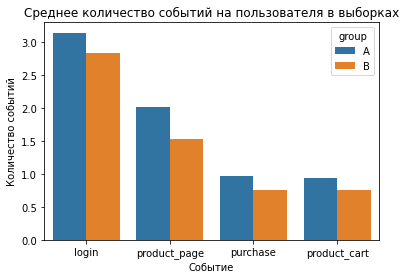

In [56]:
ax = sns.barplot(x='event_name', y='mean', data=groupsab, hue='group')
ax.set_title('Среднее количество событий на пользователя в выборках')
ax.set_xlabel('Событие') 
ax.set_ylabel('Количество событий')
plt.show()

**Вывод**
- Среднее количество событий на пользователя в группе A - 7, а в группе B - 6. 
- Исходя из графика, в группе А больше событий на пользователя по всем типам событий. Получается, что конверсия группы А выше, чем у группы В, и ожидаемый прирост в 10% ни в одном из событий (на первый взгляд) не наблюдается. 

### Распределение количества событий по дням

Посмотрим на распределение количества событий по дням для каждой из групп.

In [57]:
events_by_day = test1.groupby(['event_dt', 'group', 'event_name'])['user_id'].count().reset_index()

In [58]:
events_by_day.head()

,event_dt,group,event_name,user_id
0,2020-12-07 00:16:00,A,login,1
1,2020-12-07 00:16:00,A,product_page,1
2,2020-12-07 00:16:00,A,purchase,1
3,2020-12-07 00:25:02,B,login,1
4,2020-12-07 00:25:02,B,product_page,1


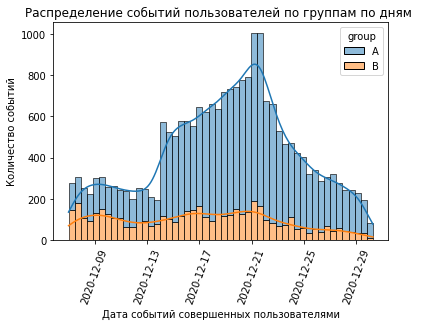

In [59]:
sns.histplot(data=events_by_day, x="event_dt", kde=True, bins=50, hue="group", multiple="stack")
plt.xlabel("Дата событий совершенных пользователями")
plt.ylabel("Количество событий")
plt.title ("Распределение событий пользователей по группам по дням ")
plt.xticks(rotation=70);

- количество событий в группе A заметно больше, чем в группе B.
- наблюдается резкий рост числа событий в группе А в период с 13 по 21 декабря.

Посмотрим распределение количества событий по дням регистрации. 

In [60]:
events_by_1day = test1.groupby(['first_date', 'group', 'event_name'])['user_id'].count().reset_index()
events_by_1day.head()

,first_date,group,event_name,user_id
0,2020-12-07,A,login,439
1,2020-12-07,A,product_cart,108
2,2020-12-07,A,product_page,277
3,2020-12-07,A,purchase,125
4,2020-12-07,B,login,535


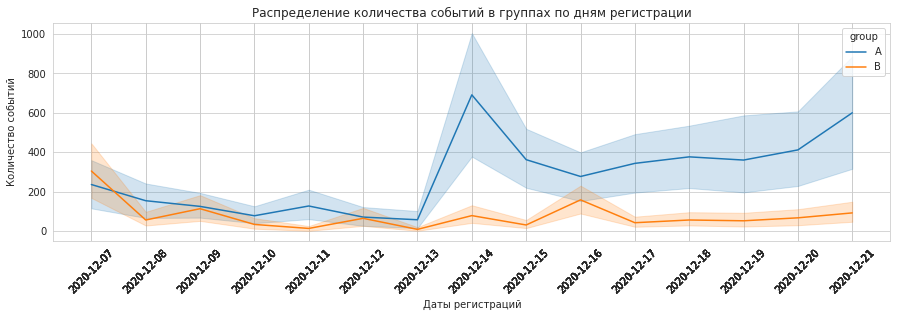

In [61]:
# строим график

plt.figure(figsize=(15, 4))
sns.set_style("whitegrid")
ax = sns.lineplot(data=events_by_1day, x='first_date', y='user_id', hue='group')
ax.set_xticks(events_by_1day['first_date'])
ax.set_title('Распределение количества событий в группах по дням регистрации')
plt.xlabel('Даты регистраций')
plt.ylabel('Количество событий')
plt.xticks(rotation=45);

Тут аналогичная ситуация, всплески событий произошли в дни регистрации с 13 по 21 декабря. Скорее всего, в эти даты большое количество участников зарегистрировалось, и отсюда всплекс по событиям.

Посмотрим, сколько пользователей зарегистрировалось в эти дни в группе А.

In [62]:
test1.query("first_date > datetime(2020, 12, 13) & first_date <= datetime(2020, 12, 21) & group == 'A'")['user_id'].nunique()

1881

1881 пользователь из 2422 пользователей в группе А зарегистрировались в этот промежуток времени, около 70%. Резкий всплеск событий на графиках связан с увеличением количества регистраций в эти дни.

**Вывод**
- Количество событий в группе A заметно больше, чем в группе B.
- С 13 по 21 декабря наблюдается резкое увеличение количества регистраций в обеих группах, но более всего в группе А.

### Изменение конверсии в воронке на разных этапах

Отфильтруем события, которые происходили только в течение 14 дней с момента регистрации. 

In [63]:
#проверим сколько уникальных пользователей сейчас в данных

test1.user_id.nunique()

3234

Установим горизонт событий - 14 дней, а последняя дата - 4 января 2021 г. Исключим пользователей, не «доживших» до горизонта анализа (`last_date`).

In [64]:
horizon_days = 14
observation_date = datetime(2021, 1, 4).date()
last_date = observation_date - timedelta(days = horizon_days - 1)

In [65]:
#отфильтруем по дате последнего набора пользователей 

test1 = test1.query('event_dt <= @last_date')

In [66]:
#добавим столбец, отображающий лайфтайм пользователя

test1['lifetime'] = (test1['event_dt'] - test1['first_date']).dt.days

In [67]:
#проверим, есть ли пользователи с лайфтаймом более 14 дней

test1.query('lifetime > 14')

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,lifetime


In [68]:
#отфильтруем с лайфтаймом менее 14 дней и пересохраним данные

test1 = test1.query('lifetime < 14')

In [69]:
#проверим количество уникальных пользователей

test1.user_id.nunique()

3234

In [70]:
#проверим лайфтайм

test1.lifetime.nunique()

14

Количество пользователей не изменилось, попробовала отфильтровать двумя способами. Возможно, что на этапе присоединения таблиц отсеяла слишком много пользователей, но не нашла ошибку в присоединении таблиц.

Построим сводную таблицу для воронки и посчитаем количество событий для каждой группы.

In [71]:
funnel = test1.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique')\
                            .reset_index()
funnel

group,event_name,A,B
0,login,2422,811
1,product_cart,728,225
2,product_page,1571,461
3,purchase,773,228


In [72]:
# Отсортируем по последовательности шагов

funnel['step'] = [1, 3, 2, 4]
funnel = funnel.sort_values(by='step')

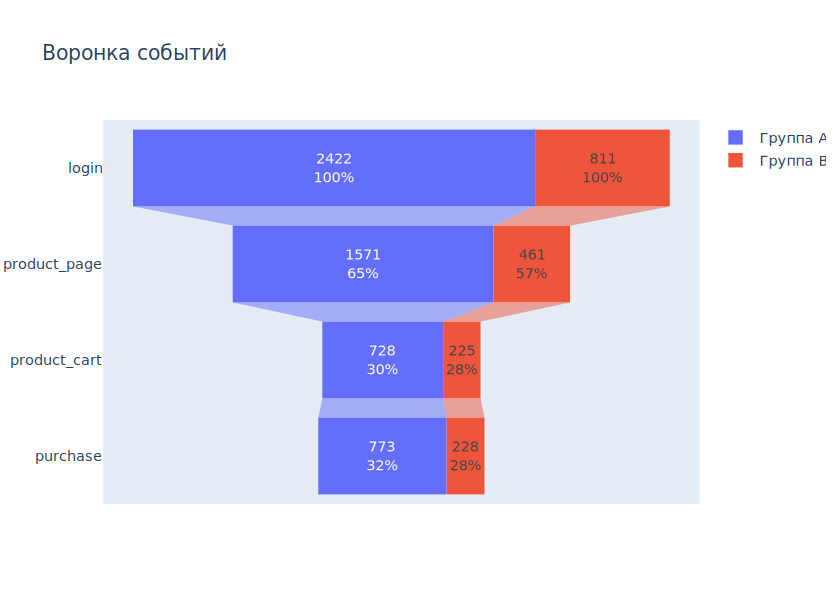

In [73]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = funnel['event_name'],
    x = funnel['A'],
    textinfo = 'value+percent initial'))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    y = funnel['event_name'],
    x = funnel['B'],
    textinfo = "value+percent initial"))

fig.update_layout(title_text='Воронка событий')
fig.show()

**Вывод**

- До покупки доходят только 32% пользователей группы А и 28% - группы В. 
- Больше всего падает коверсия между просмотром карточек товаров и просмотром корзины. Только около половины пользователей конвертируются на следующий шаг.
- Пользователей, совершивших покупку, больше, чем пользователей, просмотревших корзину, то есть шаги поменялись местами. Это значит, что совершать покупку на сайте можно не только со страницы просмотра корзины, но и через товарную карточку, например. 
- Доли перехода по всем этапам в процентном соотношении стали ниже у группы B. 

### Особенности перед A/B-тестированием

Нужно учесть следующие обнаруженные особенности перед оценкой результатов:
- Группы A и B распределены неравномерно, что уже может исказить результаты тестирования. Группа A имеет сильный перевес по количеству пользователей.
- Пользователи группы А во всех типах событий совершают больше действий, чем пользователи группы B. 
- Был всплеск регистраций с 13 по 21 декабря. В целом, можно сказать, что период тестирования был подобран неудачно, поскольку имеет влияние сезонность, то есть покупательская активность в декабре перед Новым годом резко увеличивается, и вполне возможно, что введенные в этот промежуток времени новшества могут не повлиять на пользователей в обычный период покупательской активности.
- Отсутствуют данные с 30-го декабря и по 4 января 2021 г., что сказывается на том, что у некоторых пользователей лайфтайм короче 14 дней, часть данных отсутствует.
- Доли перехода по всем этапам в процентном соотношении стали ниже у группы B.

С учетом всех этих моментов эксперимент можно признать неудачным, но все равно проверим, насколько разница в конверсии статистически значима.

## Оценка результатов A/B-тестирования

### Проверка статистической разницы долей z-критерием

Проверим, насколько разница в конверсии статистически значима. Для оценки равенства долей применим z-критерий.

Уровень статистической значимости изначально установим alpha = 0,05. Однако из-за того, что мы будем проводить множественные тесты на одинаковом наборе данных, применим поправку Бонферрони для того, чтобы снизить вероятность ошибки первого рода. Поскольку мы собираемся провести 3 попарных сравнения, то уровень alpha зададим 0.05/3 = 0.016

In [74]:
funnel1 = test1.query('event_name != "login"').groupby(['group', 'event_name'])\
                                   .agg({'user_id':'nunique'}).reset_index()
funnel1.columns = ['group', 'event_name', 'nunique_user_id']
funnel1.sort_values(by=['group', 'nunique_user_id'], ascending=[True, False])

,group,event_name,nunique_user_id
1,A,product_page,1571
2,A,purchase,773
0,A,product_cart,728
4,B,product_page,461
5,B,purchase,228
3,B,product_cart,225


Поскольку проверяем разницу в конверсии от начального этапа воронки, а это количество всех зарегистрировавшихся пользователей (то есть общее количество пользователей в группе), то добавим эти данные в отдельный столбец.

In [75]:
#добавляем количество зарегистрировавшихся пользователей

users_quant = test1.groupby('group')['user_id'].nunique()
funnel1['users_count'] = funnel1['group'].apply(lambda x: users_quant.loc[x])

In [76]:
test_a = pd.DataFrame(funnel1[funnel1['group'] == 'A']).reset_index()
display(test_a)
test_b = pd.DataFrame(funnel1[funnel1['group'] == 'B']).reset_index()
display(test_b)

,index,group,event_name,nunique_user_id,users_count
0,0,A,product_cart,728,2422
1,1,A,product_page,1571,2422
2,2,A,purchase,773,2422


,index,group,event_name,nunique_user_id,users_count
0,3,B,product_cart,225,812
1,4,B,product_page,461,812
2,5,B,purchase,228,812


In [77]:
#создадим функцию

def z_test(group_a, group_b, row, alpha):
    successes = [group_a.loc[row, 'nunique_user_id'], group_b.loc[row, 'nunique_user_id']]
    trials = [group_a.loc[row, 'users_count'], group_b.loc[row, 'users_count']]

    #пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    #пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций:
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('H0: Доли пользователей, совершивших событие {} в группах A и B, равны'.format(group_a.loc[row, 'event_name']))
    print('H1: Доли пользователей в группах не равны')
    print('p-значение', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print()
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print()

In [78]:
for i in range (0, 3):
    z_test(test_a, test_b, i, 0.016)

H0: Доли пользователей, совершивших событие product_cart в группах A и B, равны
H1: Доли пользователей в группах не равны
p-значение 0.20397790908072166
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

H0: Доли пользователей, совершивших событие product_page в группах A и B, равны
H1: Доли пользователей в группах не равны
p-значение 3.651974405083358e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница

H0: Доли пользователей, совершивших событие purchase в группах A и B, равны
H1: Доли пользователей в группах не равны
p-значение 0.04068470890052289
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

Наблюдается значимая разница долей групп А и B для события `product_page`(просмотра товарной карточки). 

Для двух других метрик p-value < альфы, а значит между долями нет значимой разницы.

## Общий вывод

Цель - оценить корректность проведения теста и проанализировать его результаты.

Выполненные задачи:
- загрузка и предобработка данных;
- проверка данных на соответствие требованиям ТЗ и основным требованиям к AB-тестированию;
- проведение исследовательского анализа данных;
- оценка результатов AB-тестирования.

В целом, воронка продаж показывает неудачные результаты теста, поскольку целевые значения в группе B не только не увеличились на 10% относительно контрольной группы, а наоборот снизились. Кроме того, период тестирования был выбран неудачно, поскольку в период новогоднего ажиотажа покупательская активность увеличивается изначально, поэтому в это время не факт, что люди стали покупать больше только из-за новых введений (рекомендуют проводить в периоды, когда нет предпраздничных активностей). 

Тем не менее, результаты пока нельзя назвать однозначно неудачными, поскольку если исправить неточности и несоответствия ТЗ, то при новой перепроверке результатов, возможно, что результаты изменятся.

**Обнаруженные несоответствия к требованиям ТЗ и проведения теста**
- Дата последнего события - 30 декабря 2020, а по ТЗ тест должен длиться до 4 января 2021, то есть недостает данных.
- С нашим временным периодом проведения теста совпадает Акция Christmas&New Year Promo, т.к. даты её проведения попадают в исследуемый период (12 декабря - 4 января), а также эта акция проводится в регионе EU.
- Изначальное деление на группы было неравномерным. В группе А - 3385 человек (57%), а в группе В - 2540 человек (43%), всего 5925 человек. 
- Есть сильный всплекс в регистрациях в группе A, из-за чего данная группа могла вырваться вперед по остальным действиям.

**Результаты z-теста**
- Подтвердилась значимая разница долей групп А и B для события `product_page`(просмотра товарной карточки), для двух других метрик между долями нет значимой разницы.

**Рекомендации по тесту**

- Проверить, не было ли технического сбоя при выгрузке данных и не потерялись ли данные с 30 декабря по 4 января. Если потерялись, то добавить их к нашим данным и заново пересмотреть.
- Проверить и скорректировать технические алгоритмы по разделению на группы, возможно стоит пересмотреть периоды и переформировать группы;

**Рекомендации по воронке продаж**
- По результатам анализа видно, что мы теряем много пользователей с перехода от регистрации к просмотру товарных карточек. Возможно, на сайте по-другому можно посмотреть товары (например, через превью, в листинге общем, а не переходя на страницу товара). 
- Также мы теряем много пользователей при переходе на страницу корзины от товарных карточек. Возможно, что переход к просмотру корзины не является обязательным действием, а значит нужно пересмотреть последовательность действий в конверсии, чтобы у покупателя был четкий отслеживаемый путь. Например, отслеживать вместо корзины - форму заполнения заказа.